In [1]:
!nvidia-smi


Thu Nov 20 02:16:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q transformers peft datasets accelerate evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


SECTION 1 – Imports & Global Config

In [3]:
import os
import copy
import random
from typing import List, Tuple

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model, PeftModel
from peft.tuners.lora import LoraLayer
import evaluate
from sklearn.metrics import classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

BASE_MODEL_NAME = "gpt2"


Using device: cuda


SECTION 2 – Load Datasets (AG News + GSM8K)

In [5]:
# AG NEWS (text classification)
agnews = load_dataset("ag_news")

# Train: 120k, Test: 7.6k
print(agnews)


# GSM8K (math reasoning)
gsm8k = load_dataset("gsm8k", "main")
print(gsm8k)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})


SECTION 3 – Preprocess Datasets for GPT-2

3.1 AG News formatting (4-class classification as generation)

In [6]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

def format_agnews_example(example):
    text = example["text"]
    label_id = example["label"]
    label = label_names[label_id]
    prompt = f"Text: {text}\nLabel:"
    target = f" {label}"
    return {"prompt": prompt, "target": target, "label": label_id}

agnews_formatted = agnews.map(format_agnews_example)
print(agnews_formatted["train"][0])


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2, 'prompt': "Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.\nLabel:", 'target': ' Business'}


In [7]:
def subsample_dataset(ds, n):
    if n is None or n >= len(ds):
        return ds
    indices = list(range(len(ds)))
    random.shuffle(indices)
    return ds.select(indices[:n])

max_train_ag = 20000   # increase if GPU is strong
max_test_ag = 4000

ag_train = subsample_dataset(agnews_formatted["train"], max_train_ag)
ag_test  = subsample_dataset(agnews_formatted["test"], max_test_ag)

len(ag_train), len(ag_test)


(20000, 4000)

3.2 GSM8K formatting (math QA as generation)

In [8]:
import re

def extract_final_answer(ans_str):
    # GSM8K answers often like "... The answer is 42."
    matches = re.findall(r"[-+]?\d+\.?\d*", ans_str)
    return matches[-1] if matches else ans_str.strip()

def format_gsm8k_example(example):
    q = example["question"]
    ans = extract_final_answer(example["answer"])
    prompt = f"Question: {q}\nAnswer:"
    target = f" {ans}"
    return {"prompt": prompt, "target": target, "final_answer": ans}

gsm8k_formatted = gsm8k.map(format_gsm8k_example)
print(gsm8k_formatted["train"][0])


Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72', 'prompt': 'Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\nAnswer:', 'target': ' 72', 'final_answer': '72'}


In [9]:
max_train_gsm = 5000
max_test_gsm = 1000

gsm_train = subsample_dataset(gsm8k_formatted["train"], max_train_gsm)
gsm_test  = subsample_dataset(gsm8k_formatted["test"], max_test_gsm)

len(gsm_train), len(gsm_test)


(5000, 1000)

SECTION 4 – Tokenizer, Base Model, and LoRA Setup

In [10]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

def load_base_model():
    model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME)
    model.to(device)
    return model

def add_lora_to_model(model):
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        target_modules=["c_attn", "c_fc", "c_proj"],  # GPT-2 linear modules
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    return model


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

SECTION 5 – Build Training Datasets for GPT-2 (LM format)

We merge prompt + target and train causal LM to generate the target.

In [11]:
def build_lm_text(example):
    full_text = example["prompt"] + example["target"]
    return {"text": full_text}

ag_train_lm = ag_train.map(build_lm_text)
ag_test_lm  = ag_test.map(build_lm_text)

gsm_train_lm = gsm_train.map(build_lm_text)
gsm_test_lm  = gsm_test.map(build_lm_text)

print(ag_train_lm[0]["text"][:300])
print(gsm_train_lm[0]["text"][:300])


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Text: Nose-Driven  #39;Nouse #39; Helps Disabled Surf Web called a  quot;nouse quot; -- works by using tracking software linked to a webcam that identifies a group of 25 pixels which are the tip of the nose.
Label: Sci/Tech
Question: Carl buys index cards for his class.  He gives each student 10 index cards.  He teaches 6 periods a day and each class has 30 students.  If a 50 pack of index cards cost $3 how much did he spend on them all?
Answer: 108


Tokenization:

In [12]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
    )

ag_train_tokenized = ag_train_lm.map(tokenize_function, batched=True, remove_columns=["text"])
ag_test_tokenized  = ag_test_lm.map(tokenize_function, batched=True, remove_columns=["text"])

gsm_train_tokenized = gsm_train_lm.map(tokenize_function, batched=True, remove_columns=["text"])
gsm_test_tokenized  = gsm_test_lm.map(tokenize_function, batched=True, remove_columns=["text"])

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

SECTION 6 – Train LoRA on AG News (LoRA_AGNEWS)

In [13]:
model_ag = load_base_model()
model_ag = add_lora_to_model(model_ag)

output_dir_ag = "lora_agnews_gpt2"

training_args_ag = TrainingArguments(
    output_dir=output_dir_ag,
    per_device_train_batch_size=4,
    num_train_epochs=2,           # you can increase to 3–4 if time allows
    learning_rate=5e-4,
    logging_steps=100,
    save_strategy="epoch",
    report_to=[],
)

trainer_ag = Trainer(
    model=model_ag,
    args=training_args_ag,
    train_dataset=ag_train_tokenized,
    eval_dataset=ag_test_tokenized,
    data_collator=data_collator,
)

trainer_ag.train()
model_ag.save_pretrained(output_dir_ag)
print("Saved LoRA_AGNEWS to", output_dir_ag)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.9391


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,4.836400
200,3.606400
300,3.515100
400,3.450000
500,3.416200
600,3.368500
700,3.324100
800,3.327500
900,3.234700
1000,3.319600


Saved LoRA_AGNEWS to lora_agnews_gpt2


SECTION 7 – Train LoRA on GSM8K (LoRA_GSM8K)

In [14]:
model_gsm = load_base_model()
model_gsm = add_lora_to_model(model_gsm)

output_dir_gsm = "lora_gsm8k_gpt2"

training_args_gsm = TrainingArguments(
    output_dir=output_dir_gsm,
    per_device_train_batch_size=4,
    num_train_epochs=2,
    learning_rate=5e-4,
    logging_steps=100,
    save_strategy="epoch",
    report_to=[],
)

trainer_gsm = Trainer(
    model=model_gsm,
    args=training_args_gsm,
    train_dataset=gsm_train_tokenized,
    eval_dataset=gsm_test_tokenized,
    data_collator=data_collator,
)

trainer_gsm.train()
model_gsm.save_pretrained(output_dir_gsm)
print("Saved LoRA_GSM8K to", output_dir_gsm)


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.9391


Step,Training Loss
100,3.624000
200,2.682600
300,2.598900
400,2.579500
500,2.541300
600,2.584500
700,2.497300
800,2.502900
900,2.493400
1000,2.464700


Saved LoRA_GSM8K to lora_gsm8k_gpt2


SECTION 8 – Inference Helpers (Generate & Evaluation)

In [15]:
def generate_text(model, prompt: str, max_new_tokens: int = 16) -> str:
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


8.1 Evaluate classification on AG News

We will ask model to complete "Label:" and then map to one of the 4 label names.

In [16]:
def predict_label_ag(model, text: str) -> int:
    prompt = f"Text: {text}\nLabel:"
    out = generate_text(model, prompt, max_new_tokens=3)
    # Get substring after "Label:"
    after = out.split("Label:")[-1].strip()
    # Try to match label
    for i, name in enumerate(label_names):
        if name.lower() in after.lower():
            return i
    # fallback: random or majority baseline
    return 0

def evaluate_agnews_classification(model, dataset):
    y_true = []
    y_pred = []

    for ex in dataset:
        y_true.append(ex["label"])
        pred = predict_label_ag(model, ex["text"])
        y_pred.append(pred)

    print(classification_report(y_true, y_pred, target_names=label_names, digits=3))
    accuracy = sum(int(t == p) for t, p in zip(y_true, y_pred)) / len(y_true)
    print(f"Accuracy: {accuracy:.3f}")
    return accuracy


8.2 Evaluate reasoning on GSM8K

Check if the final numeric answer appears in the generated text.

In [17]:
def evaluate_gsm8k_accuracy(model, dataset, max_examples=300):
    correct = 0
    total = 0

    for i, ex in enumerate(dataset):
        if max_examples and i >= max_examples:
            break
        q = ex["question"]
        gold = extract_final_answer(ex["answer"])
        prompt = f"Question: {q}\nAnswer:"
        out = generate_text(model, prompt, max_new_tokens=32)
        if gold in out:
            correct += 1
        total += 1

    acc = correct / total if total > 0 else 0.0
    print(f"GSM8K accuracy on {total} examples: {acc:.3f}")
    return acc


SECTION 9 – Reload Adapters & Evaluate SPECIALIZED models

In [18]:
# LoRA_AGNEWS model
base_ag = load_base_model()
lora_ag = PeftModel.from_pretrained(base_ag, "lora_agnews_gpt2")
lora_ag.to(device)

# LoRA_GSM8K model
base_gsm = load_base_model()
lora_gsm = PeftModel.from_pretrained(base_gsm, "lora_gsm8k_gpt2")
lora_gsm.to(device)

print("=== LoRA_AGNEWS on AG News Test ===")
acc_ag_on_ag = evaluate_agnews_classification(lora_ag, ag_test)

print("=== LoRA_GSM8K on GSM8K Test (subset) ===")
acc_gsm_on_gsm = evaluate_gsm8k_accuracy(lora_gsm, gsm_test)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== LoRA_AGNEWS on AG News Test ===


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

              precision    recall  f1-score   support

       World      0.723     0.896     0.800       981
      Sports      0.973     0.732     0.836      1000
    Business      0.866     0.836     0.851      1039
    Sci/Tech      0.857     0.900     0.878       980

    accuracy                          0.841      4000
   macro avg      0.855     0.841     0.841      4000
weighted avg      0.856     0.841     0.841      4000

Accuracy: 0.841
=== LoRA_GSM8K on GSM8K Test (subset) ===


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

GSM8K accuracy on 300 examples: 0.190


In [19]:
print("=== LoRA_AGNEWS on GSM8K (cross-task) ===")
acc_ag_on_gsm = evaluate_gsm8k_accuracy(lora_ag, gsm_test, max_examples=200)

print("=== LoRA_GSM8K on AG News (cross-task) ===")
acc_gsm_on_ag = evaluate_agnews_classification(lora_gsm, ag_test)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== LoRA_AGNEWS on GSM8K (cross-task) ===


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

GSM8K accuracy on 200 examples: 0.125
=== LoRA_GSM8K on AG News (cross-task) ===


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

              precision    recall  f1-score   support

       World      0.245     0.999     0.394       981
      Sports      1.000     0.004     0.008      1000
    Business      0.250     0.001     0.002      1039
    Sci/Tech      0.000     0.000     0.000       980

    accuracy                          0.246      4000
   macro avg      0.374     0.251     0.101      4000
weighted avg      0.375     0.246     0.099      4000

Accuracy: 0.246


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SECTION 10 – Merge LoRAs (Simple Weight Averaging)

In [20]:
def get_lora_layers(model):
    layers = {}
    for name, module in model.named_modules():
        if isinstance(module, LoraLayer):
            layers[name] = module
    return layers

def merge_two_lora_models(model_a, model_b, alpha=0.5):
    """
    new = alpha * A + (1 - alpha) * B for each LoRA weight.
    """
    merged = copy.deepcopy(model_a)

    layers_a = get_lora_layers(model_a)
    layers_b = get_lora_layers(model_b)
    layers_m = get_lora_layers(merged)

    if set(layers_a.keys()) != set(layers_b.keys()):
        raise ValueError("LoRA layer sets do not match; cannot merge.")

    for name, layer_a in layers_a.items():
        layer_b = layers_b[name]
        layer_m = layers_m[name]

        for key in layer_a.lora_A.keys():
            with torch.no_grad():
                Wa = layer_a.lora_A[key].weight.data
                Wb = layer_b.lora_A[key].weight.data
                Wm = layer_m.lora_A[key].weight.data
                Wm.copy_(alpha * Wa + (1 - alpha) * Wb)

                Ba = layer_a.lora_B[key].weight.data
                Bb = layer_b.lora_B[key].weight.data
                Bm = layer_m.lora_B[key].weight.data
                Bm.copy_(alpha * Ba + (1 - alpha) * Bb)

    return merged

# Fresh bases for merging
base_merge_1 = load_base_model()
base_merge_2 = load_base_model()

model_ag_for_merge = PeftModel.from_pretrained(base_merge_1, "lora_agnews_gpt2")
model_gsm_for_merge = PeftModel.from_pretrained(base_merge_2, "lora_gsm8k_gpt2")

merged_model = merge_two_lora_models(model_ag_for_merge, model_gsm_for_merge, alpha=0.5)
merged_model.to(device)
print("Merged LoRA model created.")


Merged LoRA model created.


SECTION 11 – Evaluate Merged Model on Both Tasks

In [21]:
print(" Merged LoRA on AG News ")
acc_merged_ag = evaluate_agnews_classification(merged_model, ag_test)

print(" Merged LoRA on GSM8K (subset) ")
acc_merged_gsm = evaluate_gsm8k_accuracy(merged_model, gsm_test, max_examples=300)

print(" SUMMARY ")
print(f"LoRA_AGNEWS on AGNews: {acc_ag_on_ag:.3f}")
print(f"LoRA_GSM8K on GSM8K : {acc_gsm_on_gsm:.3f}")
print(f"Merged on AGNews    : {acc_merged_ag:.3f}")
print(f"Merged on GSM8K     : {acc_merged_gsm:.3f}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Merged LoRA on AG News 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

              precision    recall  f1-score   support

       World      0.263     0.993     0.416       981
      Sports      0.976     0.279     0.434      1000
    Business      0.714     0.010     0.019      1039
    Sci/Tech      0.000     0.000     0.000       980

    accuracy                          0.316      4000
   macro avg      0.488     0.320     0.217      4000
weighted avg      0.494     0.316     0.215      4000

Accuracy: 0.316
 Merged LoRA on GSM8K (subset) 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

GSM8K accuracy on 300 examples: 0.133
 SUMMARY 
LoRA_AGNEWS on AGNews: 0.841
LoRA_GSM8K on GSM8K : 0.190
Merged on AGNews    : 0.316
Merged on GSM8K     : 0.133


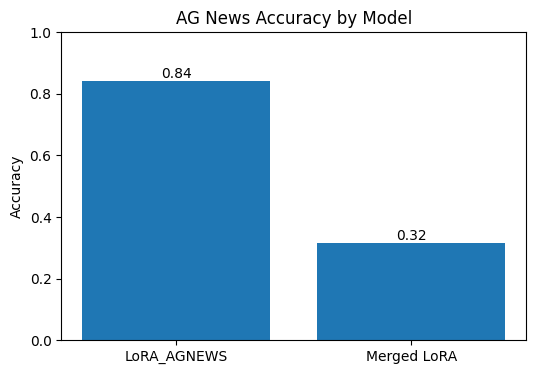

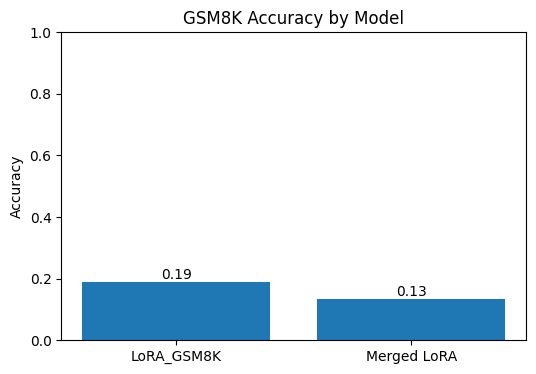

In [22]:
import matplotlib.pyplot as plt

#  AG News accuracy bar chart
models_ag = ["LoRA_AGNEWS", "Merged LoRA"]
accs_ag = [acc_ag_on_ag, acc_merged_ag]

plt.figure(figsize=(6, 4))
plt.bar(models_ag, accs_ag)
plt.title("AG News Accuracy by Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
for i, v in enumerate(accs_ag):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()

#  GSM8K accuracy bar chart
models_gsm = ["LoRA_GSM8K", "Merged LoRA"]
accs_gsm = [acc_gsm_on_gsm, acc_merged_gsm]

plt.figure(figsize=(6, 4))
plt.bar(models_gsm, accs_gsm)
plt.title("GSM8K Accuracy by Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
for i, v in enumerate(accs_gsm):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()


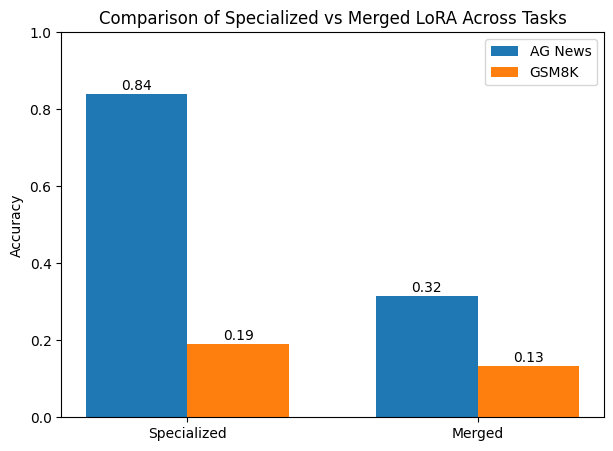

In [23]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Specialized", "Merged"]
ag = [acc_ag_on_ag, acc_merged_ag]
gsm = [acc_gsm_on_gsm, acc_merged_gsm]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, ag, width, label="AG News")
plt.bar(x + width/2, gsm, width, label="GSM8K")

plt.ylabel("Accuracy")
plt.title("Comparison of Specialized vs Merged LoRA Across Tasks")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.legend()

for i, v in enumerate(ag):
    plt.text(x[i] - width/2, v + 0.01, f"{v:.2f}", ha="center")
for i, v in enumerate(gsm):
    plt.text(x[i] + width/2, v + 0.01, f"{v:.2f}", ha="center")

plt.show()
